# Understanding Visual Analytics with Statistics

Visual storytelling plays a significant role in the decision-making process, so, naturally, we hope our stories are sufficiently accurate, and they adequately represent the information from the available data. Unfortunately, being good at story-telling with numbers and graphs is not as intuitive as our inherent ability to make sense of the world through fundamental interactions and observations. 

In this blog post, we will take a look at how to intuitively connect the language of math, here probability and statistics, with the visual representations of the analysis. 

Most frequently, we are interested in visualizing _univariate_ (one variable) and _bivariate_ (two variables) distributions, as well as discovering their mutual relations (comparisons between the variables). Here, we will look into three types of probabilities - _joint_, _marginal_, and _conditional_ - and show how different kinds of visualizations arise from those fundamental concepts. 



### Joint Probability Distribution

A _joint probability_ expresses a likelihood of two different events occurring at the same time, for example, an event of _umbrella_ and an event of _rain_ (for a discrete case), or events representing _height_ and _weight_ (for a continuous case). 

Mathematically, the joint probability distribution is expressed as:

$$f(x,y)=P(X=x,Y=y)$$

Let us generate two continuous random variables and show how to visualize their joint probability distribution.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


Generate 100 data points for two random variables, _a_, and _b_ that are normally distributed around 0 with a small standard deviation of 0.1 (the spread of the data).

In [2]:
df1 = pd.DataFrame(np.random.normal(loc=0, scale=0.1, size=(100, 2)), columns=["a", "b"])

In [3]:
df1.head()

,a,b
0,0.113440,-0.005401
1,0.078218,0.121819
2,0.019657,0.041097
3,-0.085296,-0.117608
4,-0.142860,0.076745


Seaborn library provides a very convenient interface for computing the joint probability distribution for our random variables. By our generation method, we expect the significant mass of data points to be concentrated around 0 and slowly falling off. You can see that by observing the highest density in the center of the coordinate system, with each subsequent layer losing its intensity as it moves away from the center.

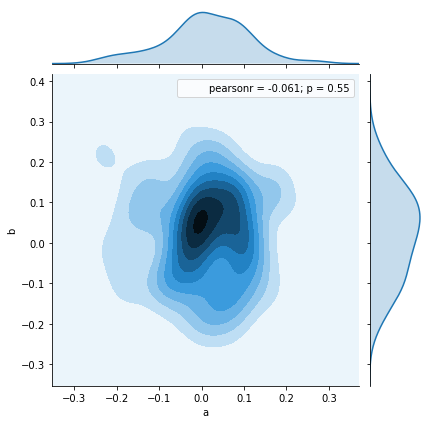

In [4]:
sns.jointplot(x="a", y="b", data=df1, kind='kde');

Let's do a similar excursion this for a discrete case of random variables, but this time we shall select a different visualization technique.

In [5]:
df2 = pd.DataFrame(np.random.randint(low=1, high=4, size=(1000, 2)), columns=["a", "b"])
# dummy variable to facilitate counting
df2["frequency"] = 1

In [6]:
df2.head()

,a,b,frequency
0,2,1,1
1,2,3,1
2,1,2,1
3,1,1,1
4,3,2,1


Below we are going to compute the frequencies of variable's configurations occurring together. This is essentially the _unnormalized joint probability distribution_ (to normalize it, just divide it by their total number)

In [7]:
df_grouped = df2.groupby(["a", "b"])[["frequency"]].count().unstack("b")
# minor massage of the data to tidy up the column names
df_grouped.columns = df_grouped.columns.get_level_values(1)

In [8]:
df_grouped

b,1,2,3
a,,,
1,90,95,108
2,116,120,110
3,129,131,101


We are going to use a _heatmap_ representation of the data to estimate the likelihood of each combination of available states. The color saturation provides excellent visual cues on how the data is distributed and what are the extreme points (maximum and minimum). We observe that the most likely state is the combination (1,3) and the less likely is (2,2). 

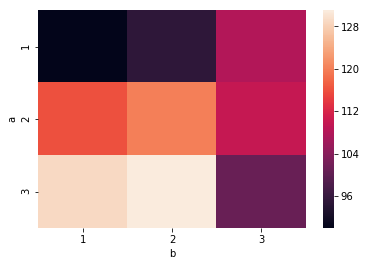

In [9]:
sns.heatmap(df_grouped);

Using these two representations - density estimation and a heat map -  can help us make sense of the data, and accompany the decision-making process with an intuitive explanation of the reasoning. Now, let's us move on the __marginal probability distribution__ that is computed from the joint probability distribution.

### Marginal Probability Distribution

This probability distribution might sound complicated. However, it is the most intuitive of the three because, in the end, it represents a single random variable irrespective of other variables. Every time we are computing a histogram of one variable, we are seeking its marginal distribution, where the variable is analyzed in isolation (therefore, other variables are being "marginalized out"). 

Mathematically, the marginal probability is derived directly from the joint probability:

$$P(X=x) = \sum_{y}{P(X=x, Y=y)}$$

Our previous _jointplot_ generated for the continuous variables is handy for seeing the _marginals_ as well. It is captured by those "mounts" on the top and on the right side of the graph for variables _a_ and _b_ respectively. It is a "shop in one place" concept.

For the discrete case, we can obtain the marginal distribution by aggregating and slicing the corresponding events.

In [10]:
df_marg = df2.groupby("a")[["b"]].count() / df2.groupby("a")["b"].count().sum()

The simple bar-chart visualization is sufficient to communicate marginal probability distribution of the variable _a_.

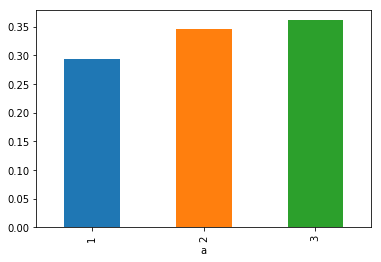

In [11]:
df_marg['b'].plot.bar();

Sometimes, it is convenient to _stack_ the bars to convey the share of each state in the total space of available states for the given variable. This reduces the cognitive load of having to compare different categories and helps the audience focus on the message.

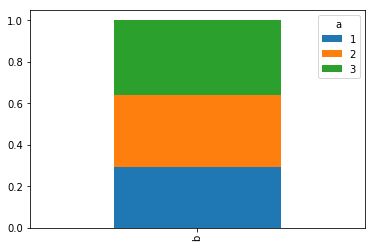

In [12]:
df_marg[['b']].T.plot.bar(stacked=True);

Since _marginals_ are focused on single variables, in contrast with joint distributions, it is a good idea to use visualization techniques designed for univariate variables, to remove the clutter and highlight the signal.

### Conditional Probability Distribution

Finally, let's look at the _conditional probability distribution_, which estimates a probability distribution of some variable $Y$ given $X$ is fixed to a particular state. This is useful when we already know the state of one variable (for example, it is raining outside), and we would like to estimate the probability of the particular state for another variable that is _dependent_ on the first (for example, what is the probability of seeing an umbrella outside). 

Mathematically, the conditional distribution can be computed using joint and the marginal distributions:

$$P(X|Y) = \frac{P(X,Y)}{P(Y)}$$

Let's explore some visual manifestations of the conditional distributions. When we condition one variable on the values of other variables, we seek to rank the attributes of our data to order to optimize some predefined objective that drives the orientation of the graph. 

In [13]:
cond_df = df2.groupby(['a', 'b'])[["frequency"]].count() / df2.groupby(['a', 'b'])["frequency"].count().sum()
cond_df.columns = ["probability"]

In [14]:
cond_df

probability
a b             
1 1        0.090
  2        0.095
  3        0.108
2 1        0.116
  2        0.120
  3        0.110
3 1        0.129
  2        0.131
  3        0.101

The decision point on orienting the graph is contingent on the nature of the analysis. Organizing the categories vertically (horizontal bar) makes sense when the decision relies on analyzing the order of assignments. Avoiding contrasting colors can aid signaling the importance of the arrangement (relative positions) vs. arbitrary color attributes.    

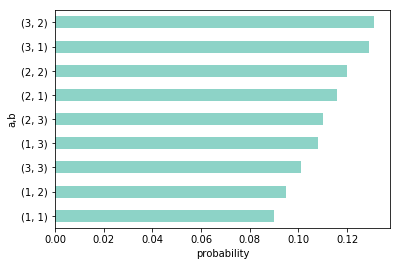

In [15]:
cond_df["probability"].sort_values().plot.barh(colormap='Set3');
plt.xlabel("probability");

Let's demonstrate a slightly more involved scenario where we are looking at a relation between two variables by conditioning them on another variable. For that we shall add a third variable to our generated dataset of two continuous random variables:

In [16]:
# let's mark some points as anomalous if they points land beyond 0.2
df1['class'] = np.where((df1['a'] > 0.2) | (df1['b'] > 0.2),'anomaly','normal')

In [17]:
# let see the relative count of each class
df1["class"].value_counts()

normal     91
anomaly     9
Name: class, dtype: int64

We are interested in investigating the relationship between two variables as a function of the third, and more specifically how the relation changes. Here, we observe the two continuous variables interacting with a categorical variable, and to distinguish between them we separate the correlations with different colors (this is where the contrast helps the focus instead of dragging the attention away).

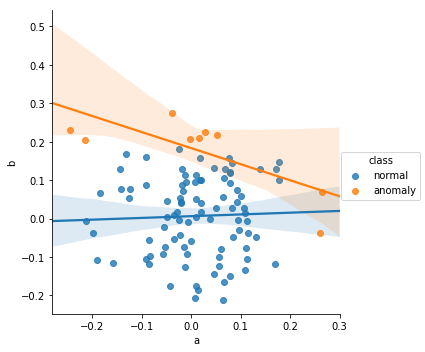

In [18]:
sns.lmplot(x="a", y="b", hue="class", data=df1, fit_reg=True);

### Conclusions

In our short journey, we explored three kinds of probability distributions - joint, marginal and conditional. Their intentions are leveraged with various visualization techniques, and we demonstrated a few that we find particularly well suited for visual storytelling. The effective language of mathematics helps to ask the right questions about our data attributes, and on-point visualization makes it easier to see the answers.

### References

To be added...

In [19]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()